# Задача прогнозирования оттока клиентов телеком-оператора

## Описание проекта :

Вам предоставляется отчет и набор данных от телекоммуникационной компании. 
Данные содержат информацию о более чем трех тысячах пользователей, их демографических характеристиках, услугах, которыми они пользуются, длительности использования услуг оператора и сумме оплаты.

Задача - проанализировать данные и спрогнозировать отток пользователей (выявить людей, которые будут и не будут продлевать свой контракт).
Удержание пользователей - одна из наиболее актуальных задач в областях, где распространение услуги составляет порядка 100%. Ярким примером такой области является сфера телекома. Удержание клиента обойдется компании дешевле, чем привлечение нового.

Прогнозируя отток, мы можем вовремя среагировать и постараться удержать клиента, который хочет уйти. На основании данных об услугах, которыми пользуется клиент, мы можем сделать ему специальное предложение, пытаясь изменить его решение покинуть оператора. Это сделает задачу удержания проще в реализации, чем задачу привлечения новых пользователей.
На основе полученных данных мы построили первый вариант прогнозирующей модели.

----Дописано------
Команда DS проверяет возможно и эффективно ли строить и применять модель оттока. Если да, то обучается модель, проводится A/B тест. 
Если результаты A/B теста экономически и статестически значимы, то принимается решение о внедрении в продакшн. 
Комадне разработки даётся задание подготовить соответствующий функционал в мобильном приложении, а также автоматическую рассылку на почту и телефон.
После этого выбирается периодичность с которой будет производится анализ на предмет оттока. В результате этого на серверах компании появляется соответствующая информация.
Дальше, в соотвествии с ожидаемым оттоком клиенты, получают информацию об акции/скидке и прочем.(всё это автоматизировано командой разрабокти)
Через некоторое время комадна DS, проверяет, что всё идёт хорошо, A/B тест подтвердился, отток уменьшился.

## Бизнес - цель :

Цель - уменьшить количество уходящих клиентов. 

------Дописать-----
Сформулируйте бизнес-цель:
- Как вы будете её измерять?
- Каков критерий успеха?


это пример, надо переделать:

(Тестировать модель лучше всего рассматривая экономический эффект, так как экономический эффект от внедрения модели будет показывать реальный результат работы, так же это позволит получить детальную информацию о цене ошибок первого и второго рода. 
Критерием успешности можно считать увеличение площади ROC-кривой на 15-20% и увеличение экономического эффекта после AB-тестирования.)



## Математическая задача :

Для достижения цели будем решать задачу бинарной классификации: отток/не отток.

В качестве базовой модели будем использовать Random Forest Classifier.
Разработанная модель прогнозирования позволит находить клиентов, склонных к оттоку по их поведению и для проведения последующих мероприятий, связанных с удержанием клиентов.

Т.к. классы не сбалансированы, будем использовать метрику ROC-AUC.


## Валидация данных и оценка потенциала модели :

In [ ]:
import numpy as np
import pandas as pd

Визуализируем данные :

In [ ]:
#df = pd.read_csv('https://drive.google.com/file/d/1QCPFFyYe-a65GZhiNxnA0GMkpunfjFS4')

url='https://drive.google.com/file/d/1QCPFFyYe-a65GZhiNxnA0GMkpunfjFS4/view?usp=sharing'
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url2)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Датасет содержит следующие поля :
- State (Код штата) 
- Account length (Срок обслуживания клиента компанией)
- Area code (Префикс номера телефона)
- International plan (Подключен ли международный роуминг)
- Voice mail plan (Подключена ли международная почта)
- Number vmail messages (Количество голосовых сообщений)
- Total day minutes (Суммарная длительность разговоров днём)
- Total day calls (Количество звонков днём)
- Total day charge (Сумма оплаты за услуги днём)
- Total eve minutes (Суммарная длительность разговоров вечером)
- Total eve calls (Количество звонков вечером)
- Total eve charge (Сумма оплаты за услуги вечером)
- Total night minutes (Суммарная длительность разговоров ночью)
- Total night calls (Количество звонков ночью)
- Total night charge (Сумма оплаты за услуги ночью)
- Total intl minutes (Суммарная длительность международных разговоров)
- Total intl calls (Количество международных звонков )
- Total intl charge (Сумма оплаты за международные разговоры)
- Customer service calls (Число обращений в сервисный центр)
- Churn (Отток ?) - целевая переменная

In [ ]:
#посмотрим на размер данных

print(df.shape)

(3333, 20)


In [ ]:
# посмотрим на информацию о типах данных :

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

Выделим следующие группы признаков в рассматриваемом датасете :
- бинарные: "International plan", "Voice mail plan"
- категориальные: "State"
- порядковые: "Customer service calls"
- все остальные признаки относятся к количественным 

Произведём преобразования признаков для дальнейшего удобства :

In [ ]:
df["Churn"] = df["Churn"].astype("int64")
d = {"No": False, "Yes": True}
df["International plan"] = df["International plan"].map(d)

Начнём с определения доли оттока в рассматриваемом датасете и визуализируем эту долю :
    

In [ ]:
df['Churn'].mean()  

0.14491449144914492

Text(0.5, 1.0, 'Распределение оттока клиентов')

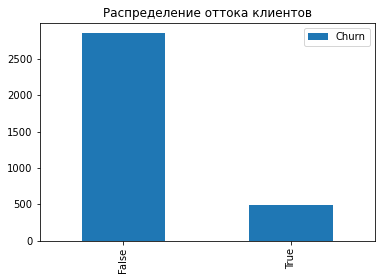

In [ ]:
df['Churn'].value_counts().plot(kind='bar', label='Churn')
plt.legend()
plt.title('Распределение оттока клиентов')

14.5% нелояльных пользователей для компании - довольно высокая цифра, построение модели для прогнозирования доли оттока пользователей с целью изучения причин оттока и планирования дальнейших шагов для удержания ЦА в таких кейсах является очень актуальной задачей.

Посмотрим на данные по длительности минут в разное время суток в зависимости от признака "Churn" :
    
    

In [ ]:
columns_to_show = ["Total day minutes", "Total eve minutes", "Total night minutes"]

df.groupby(["Churn"])[columns_to_show].describe(percentiles=[])

Total day minutes                                            \
                  count        mean        std  min    50%    max   
Churn                                                               
False            2850.0  175.175754  50.181655  0.0  177.2  315.6   
True              483.0  206.914079  68.997792  0.0  217.6  350.8   

      Total eve minutes                                             \
                  count        mean        std   min    50%    max   
Churn                                                                
False            2850.0  199.043298  50.292175   0.0  199.6  361.8   
True              483.0  212.410145  51.728910  70.9  211.3  363.7   

      Total night minutes                                              
                    count        mean        std   min     50%    max  
Churn                                                                  
False              2850.0  200.133193  51.105032  23.2  200.25  395.0  
True                483.0  205.231677  47.132825  47.4  204.80  354.9

Интересной особенностью задачи является то, что в среднем нелояльные клиенты пользуются связью больше лояльных (нагляднее всего это наблюдается днём)

Построим матрицу корреляций количественных признаков :

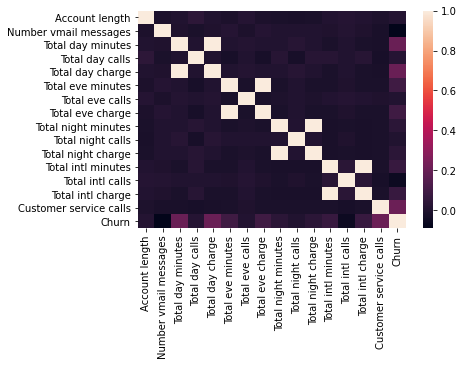

In [ ]:
corr_matrix = df.drop(['State', 'International plan', 'Voice mail plan',
                      'Area code'], axis=1).corr()
sns.heatmap(corr_matrix)

Учитывая линейную взаимосвязь между признаками "Total day charge" и "Total day minutes" (по вечерним, ночным и международным
звонкам ситуация аналогичная), признаки "Total day minutes", "Total eve minutes", "Total night minutes", "Total intl minutes" 
можно удалить, полезной информации они не несут

Посмотрим теперь на распределения признаков :

C:\Users\user\Anaconda3.1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\user\Anaconda3.1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\user\Anaconda3.1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

C:\Users\user\Anaconda3.1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\user\Anaconda3.1\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\user\Anaconda3.1\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


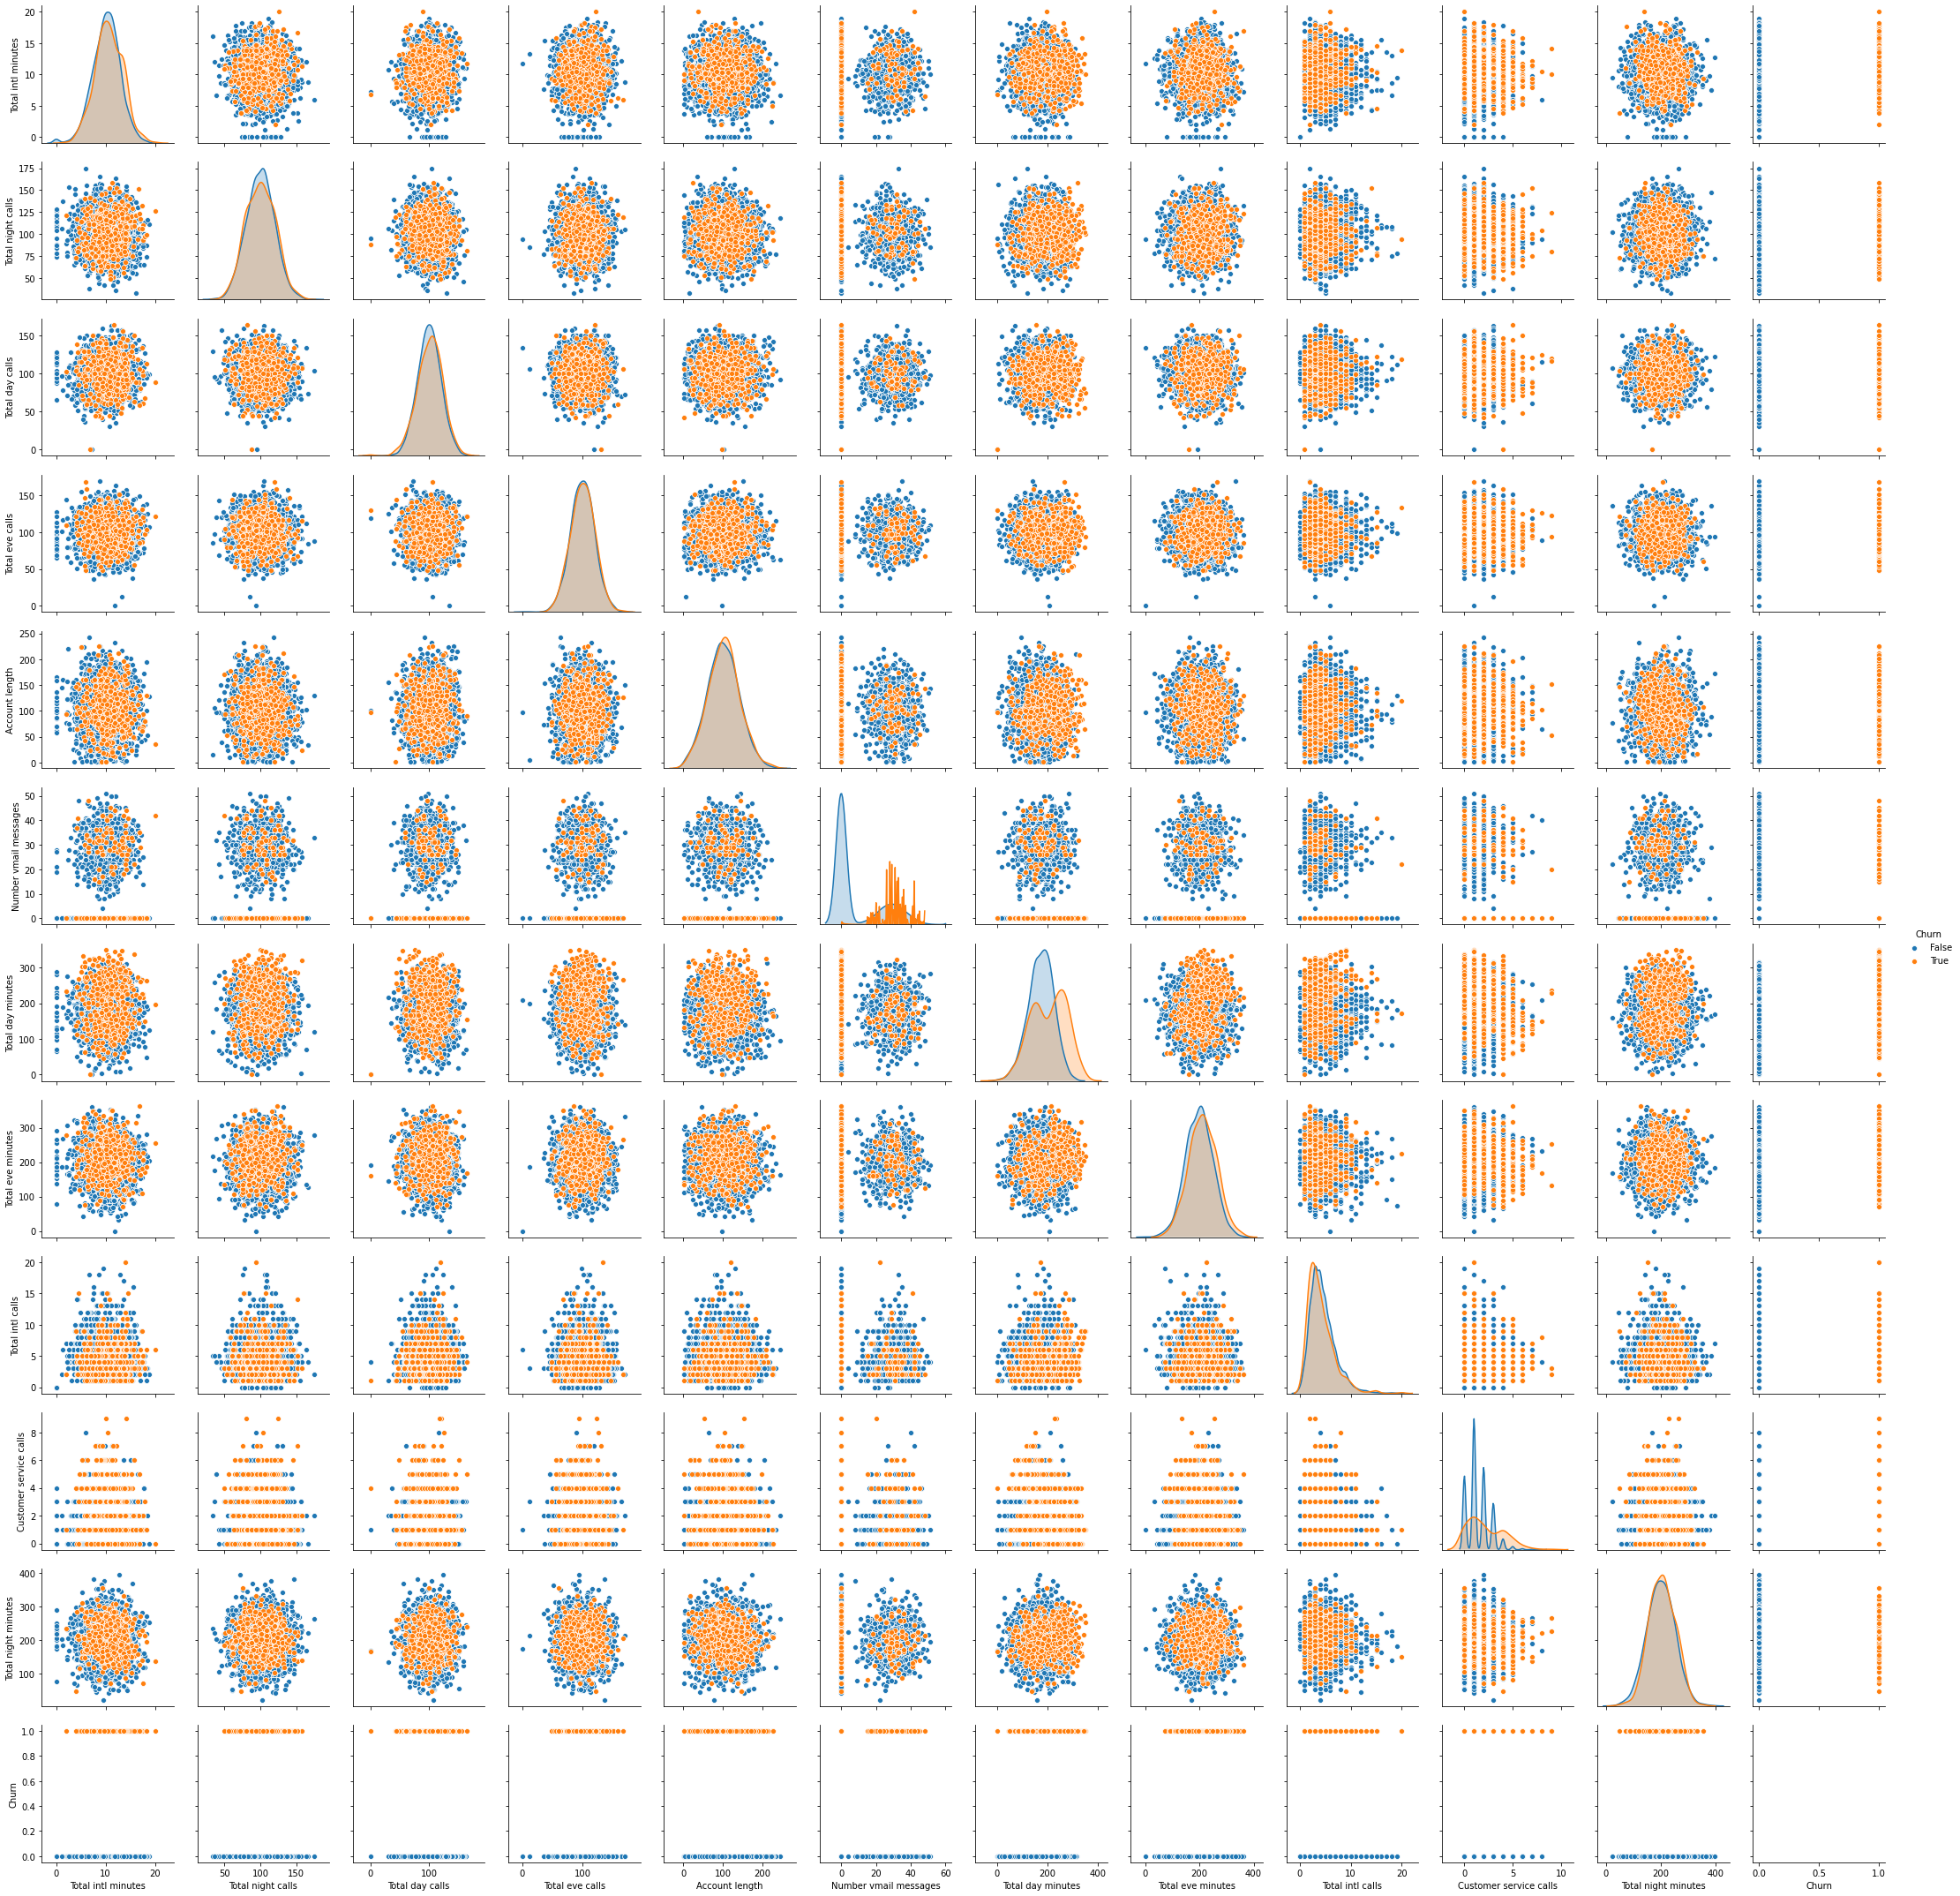

In [ ]:
features = list(set(df.columns) - set(['State', 'International plan', 'Voice mail plan',  'Area code',
                                      'Total day charge',   'Total eve charge',   'Total night charge',
                                        'Total intl charge', 'Churn']))

sns.pairplot(df[features + ['Churn']], hue='Churn')

Картины попарных распределений признаков говорят о том, что в рассматримаемом датасете существуют такие пары переменных, в которых 
данные становятся достаточно хорошо разделимы нелинейной поверхностью. Таким образом, помимо начальных предположений относительно зависимости оттока от наличия у клиента международного роуминга или количества обращений в сервисный центр, которые могут стать
основой для построения базовой модели, рассматриваемая задача классификации может быть решена с помощью построения композиции моделей, учитывающих нелинейную взаимосвязь в данных (например, с помощью случайного леса или градиентного бустинга)


### Базовая модель :

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 6)

In [ ]:
pd.crosstab(df["Churn"], df["International plan"], margins=True)

International plan,No,Yes,All
Churn,,,
0,2664,186,2850
1,346,137,483
All,3010,323,3333


Видим, что доля оттока гораздо выше у клиентов с наличием международого роуминга :
    

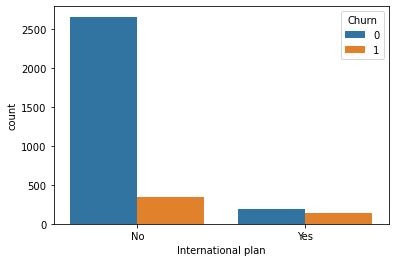

In [ ]:
sns.countplot(x="International plan", hue="Churn", data=df)
plt.savefig("int_plan_and_churn.png", dpi=300);

Построим график обращений в сервисный центр :

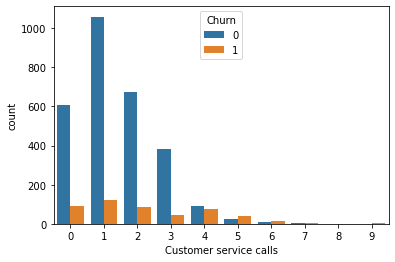

In [ ]:
sns.countplot(x="Customer service calls", hue="Churn", data=df)
plt.savefig("serv_calls__and_churn.png", dpi=300);

Видим, что доля оттока растёт, начиная с 4-ёх обращений в сервисный центр. Тогда введём новый признак, 

In [ ]:
df["Many_service_calls"] = (df["Customer service calls"] > 3).astype("int")

pd.crosstab(df["Many_service_calls"], df["Churn"], margins=True)

Churn,0,1,All
Many_service_calls,,,
0,2721,345,3066
1,129,138,267
All,2850,483,3333


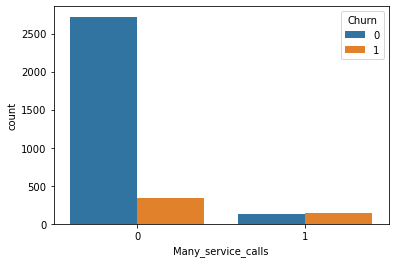

In [ ]:
sns.countplot(x="Many_service_calls", hue="Churn", data=df)
plt.savefig("many_serv_calls__and_churn.png", dpi=300);

In [ ]:
pd.crosstab(df["Many_service_calls"] & df["International plan"], df["Churn"])

Churn,0,1
row_0,,
False,2841,464
True,9,19
